# NVIDIA RAG Blueprint - Quick Start Guide

This notebook walks you through deploying and using the NVIDIA RAG (Retrieval-Augmented Generation) system.

## What is RAG?

RAG is a technique that improves AI responses by:
1. **Storing** your documents as searchable vectors (like an index)
2. **Searching** for relevant content when you ask a question
3. **Generating** an answer using only the retrieved context

Think of it like `grep` for AI - it finds relevant text first, then answers based on what it found.

---

## Table of Contents

| Section | Description | Time |
|---------|-------------|------|
| **0. Setup** | Install dependencies, define helper functions | 2 min |
| **1. Prerequisites** | Check hardware/software requirements | 2 min |
| **2. Deploy** | Start all Docker containers | 10-15 min |
| **3. Test APIs** | Verify services are working | 5 min |
| **4. Use the Chatbot** | Upload docs, ask questions | 5 min |
| **5. Cleanup** | Stop containers, free resources | 1 min |

---

## ⚠️ Before You Start

- **GPU Required**: NVIDIA GPU(s) with 80GB+ VRAM total
- **API Key Required**: Get one from https://org.ngc.nvidia.com/setup/api-keys
- **Disk Space**: ~50GB for model cache
- **Memory**: 32GB+ RAM recommended

---

# Section 0: Setup

---

Run these cells once to set up the environment.

### 0.1 Install Required Python Packages

In [ ]:
# Install dependencies (run once)
import sys
try:
    import pip  # noqa
except ImportError:
    !{sys.executable} -m ensurepip --upgrade

!{sys.executable} -m pip install -q python-dotenv aiohttp requests

### 0.2 Load Helper Functions

All utility functions are defined in this cell. **Run it once before proceeding.**

In [ ]:
"""
NVIDIA RAG Blueprint - Helper Functions
=======================================
Run this cell once to load all utilities.
"""

import os
import sys
import json
import subprocess
import asyncio
import aiohttp
from typing import List, Optional
from pathlib import Path


# =============================================================================
# CONFIGURATION - Edit these if services run on different hosts
# =============================================================================

IPADDRESS = "0.0.0.0"
RAG_SERVER_PORT = "8081"
INGESTOR_SERVER_PORT = "8082"
MILVUS_ENDPOINT = "http://milvus:19530"

RAG_BASE_URL = f"http://{IPADDRESS}:{RAG_SERVER_PORT}"
INGESTOR_BASE_URL = f"http://{IPADDRESS}:{INGESTOR_SERVER_PORT}"


# =============================================================================
# DOCKER COMPOSE HELPERS
# =============================================================================

def docker_compose(yaml_file: str, action: str, args: str = "", profile: str = "") -> bool:
    """Run docker compose command.
    - Suppresses image pull noise
    - Surfaces full error output on failure
    """

    profile_arg = f"--profile {profile}" if profile else ""
    cmd = f"docker compose -f {yaml_file} {profile_arg} {action} {args}".strip()
    cmd = " ".join(cmd.split())  # Clean up extra spaces

    # Actions that may pull images implicitly
    QUIET_ACTIONS = {"pull", "up"}

    print_prefix = "Pulling images" if action == "pull" else "Running"

    if action in QUIET_ACTIONS:
        print(f"{print_prefix} from {yaml_file}...", flush=True)

        result = subprocess.run(
            cmd,
            shell=True,
            env=os.environ,
            stdout=subprocess.PIPE,    # capture
            stderr=subprocess.PIPE,    # capture
            text=True,
        )

        if result.returncode == 0:
            print(f"✅ {action} complete", flush=True)
            return True

        # ---- Failure path: show diagnostics ----
        print(f"❌ {action} failed", flush=True)

        if result.stdout:
            print("\n--- STDOUT ---")
            print(result.stdout)

        if result.stderr:
            print("\n--- STDERR ---")
            print(result.stderr)

        return False

    # ---- Non-quiet actions: stream output ----
    print(f"$ {cmd}", flush=True)
    result = subprocess.run(cmd, shell=True, env=os.environ)

    if result.returncode == 0:
        print(f"✅ {action} succeeded", flush=True)
        return True

    print(f"❌ {action} failed (exit code {result.returncode})", flush=True)
    return False

def check_containers():
    """Show all running Docker containers."""
    subprocess.run('docker ps --format "table {{.Names}}\t{{.Status}}"', shell=True)


# =============================================================================
# API HELPERS
# =============================================================================

async def api_get(url: str, params: dict = None) -> dict:
    """Make async GET request."""
    async with aiohttp.ClientSession() as session:
        async with session.get(url, params=params) as resp:
            if resp.status != 200:
                text = await resp.text()
                print(f"❌ API error {resp.status}: {text[:200]}")
                return {"error": text, "status": resp.status}
            try:
                return await resp.json()
            except:
                text = await resp.text()
                return {"error": text, "raw": True}


async def check_health(base_url: str, name: str) -> bool:
    """Check if service is healthy."""
    try:
        await api_get(f"{base_url}/v1/health")
        print(f"✅ {name} is healthy")
        return True
    except Exception as e:
        print(f"❌ {name} not responding: {e}")
        return False


# =============================================================================
# COLLECTION MANAGEMENT
# =============================================================================

async def create_collection(name: str, collection_type: str = "text") -> dict:
    """Create a new collection in the vector database."""
    url = f"{INGESTOR_BASE_URL}/v1/collections"
    params = {
        "vdb_endpoint": MILVUS_ENDPOINT,
        "collection_type": collection_type
    }
    async with aiohttp.ClientSession() as session:
        async with session.post(url, params=params, json=[name]) as resp:
            if resp.status == 200:
                print(f"✅ Created collection: {name}")
            else:
                text = await resp.text()
                print(f"Collection response: {resp.status} - {text[:100]}")
            try:
                return await resp.json()
            except:
                return {"status": resp.status}


async def list_collections() -> list:
    """List all vector database collections."""
    result = await api_get(
        f"{INGESTOR_BASE_URL}/v1/collections",
        {"vdb_endpoint": MILVUS_ENDPOINT}
    )
    collections = result.get("collections", [])
    print(f"Collections ({len(collections)}):")
    for c in collections:
        print(f"  • {c.get('collection_name', c)}")
    return collections


async def delete_collection(name: str):
    """Delete a collection."""
    async with aiohttp.ClientSession() as session:
        params = {"vdb_endpoint": MILVUS_ENDPOINT, "collection_names": [name]}
        async with session.delete(
            f"{INGESTOR_BASE_URL}/v1/collections", params=params
        ) as resp:
            print(f"Deleted collection: {name}")
            return await resp.json()


# =============================================================================
# DOCUMENT MANAGEMENT
# =============================================================================

async def upload_documents(filepaths, collection: str = "multimodal_data") -> dict:
    """
    Upload document(s) to vector database in a single request.
    
    Args:
        filepaths: Single filepath (str), list of filepaths, or directory path
        collection: Target collection name (must exist before uploading)
    
    Returns:
        Response dict with task_id for tracking upload status
    
    Chunking options:
        - chunk_size: 1024 tokens
        - chunk_overlap: 150 tokens
    """
    # Handle single file, list, or directory
    if isinstance(filepaths, str):
        if os.path.isdir(filepaths):
            # It's a directory - get all files
            filepaths = [
                os.path.join(filepaths, f) 
                for f in os.listdir(filepaths) 
                if os.path.isfile(os.path.join(filepaths, f))
            ]
        else:
            filepaths = [filepaths]
    
    # Configure upload parameters
    data = {
        "vdb_endpoint": MILVUS_ENDPOINT,
        "collection_name": collection,
        "split_options": {
            "chunk_size": 1024,
            "chunk_overlap": 150
        }
    }
    
    # Prepare multipart form data with all files
    form_data = aiohttp.FormData()
    for filepath in filepaths:
        form_data.add_field(
            "documents",
            open(filepath, "rb"),
            filename=os.path.basename(filepath),
            content_type="application/pdf"
        )
        print(f"📤 Adding: {os.path.basename(filepath)}")
    form_data.add_field("data", json.dumps(data), content_type="application/json")
    
    # Upload all documents in single request
    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(
                f"{INGESTOR_BASE_URL}/v1/documents", data=form_data
            ) as resp:
                result = await resp.json()
                task_id = result.get("task_id", "")
                print(f"✅ Upload started → Task ID: {task_id}")
                return result
        except aiohttp.ClientError as e:
            print(f"❌ Upload error: {e}")
            return {"error": str(e)}


async def check_upload_status(task_id: str) -> dict:
    """Check document upload status."""
    result = await api_get(
        f"{INGESTOR_BASE_URL}/v1/status",
        {"task_id": task_id}
    )
    print(f"Task {task_id[:8]}...: {result.get('state', 'UNKNOWN')}")
    return result


async def list_documents(collection: str = "multimodal_data") -> list:
    """List documents in collection."""
    result = await api_get(
        f"{INGESTOR_BASE_URL}/v1/documents",
        {"collection_name": collection, "vdb_endpoint": MILVUS_ENDPOINT}
    )
    docs = result.get("documents", [])
    print(f"Documents in '{collection}' ({len(docs)}):")
    for d in docs:
        print(f"  • {d.get('document_name', d)}")
    return docs


async def delete_document(filenames, collection: str = "multimodal_data"):
    """Delete document(s) from collection. Accepts single filename or list."""
    if isinstance(filenames, str):
        filenames = [filenames]
    
    async with aiohttp.ClientSession() as session:
        params = {"collection_name": collection, "vdb_endpoint": MILVUS_ENDPOINT}
        async with session.delete(
            f"{INGESTOR_BASE_URL}/v1/documents",
            params=params,
            json=filenames
        ) as resp:
            for f in filenames:
                print(f"🗑️  Deleted: {f}")
            return await resp.json()


# =============================================================================
# CHAT / QUERY
# =============================================================================

async def chat(question: str, use_rag: bool = True, collection: str = "multimodal_data", 
               show_citations: bool = True) -> str:
    """
    Ask a question to the RAG system.
    
    Args:
        question: Your question
        use_rag: If True, search documents first (default). If False, use LLM only.
        collection: Collection to search
        show_citations: If True, print sources used to generate the response
    
    Returns:
        The AI response text
    """
    payload = {
        "messages": [{"role": "user", "content": question}],
        "use_knowledge_base": use_rag,
        "collection_names": [collection] if use_rag else [],
        "temperature": 0.2,
        "model": "nvidia/llama-3.3-nemotron-super-49b-v1.5"
    }

    async with aiohttp.ClientSession() as session:
        async with session.post(
            f"{RAG_BASE_URL}/v1/chat/completions", json=payload
        ) as resp:
            content_type = resp.headers.get("Content-Type", "")
            
            if "text/event-stream" in content_type:
                # Handle streaming response - read full response first
                response_text = await resp.text()
                concatenated_content = ""
                citations = None
                
                for line in response_text.split("\n"):
                    if line.startswith("data: "):
                        json_str = line[6:]
                        if json_str.strip() == "[DONE]":
                            continue
                        try:
                            data = json.loads(json_str)
                            content = data.get("choices", [{}])[0].get("delta", {}).get("content", "")
                            concatenated_content += content
                            # Citations are in the first chunk
                            if citations is None and "citations" in data:
                                citations = data.get("citations", {})
                        except json.JSONDecodeError:
                            continue
                
                print(concatenated_content)
                
                # Print citations if available and requested
                if show_citations and use_rag and citations:
                    results = citations.get("results", [])
                    if results:
                        print("\n" + "-" * 60)
                        print(f"📚 SOURCES ({len(results)} citations):")
                        print("-" * 60)
                        for i, src in enumerate(results, 1):
                            doc_name = src.get("document_name", "unknown")
                            doc_type = src.get("document_type", "text")
                            score = src.get("score", 0)
                            content_preview = src.get("content", "")[:150].replace("\n", " ")
                            # Skip base64 image content in preview
                            if content_preview.startswith(("/9j/", "iVBOR")):
                                content_preview = "[Image content]"
                            print(f"[{i}] {doc_name} ({doc_type}) - Score: {score:.4f}")
                            print(f"    {content_preview}...")
                
                return concatenated_content
            else:
                # Handle regular JSON response
                response_json = await resp.json()
                if "error" in response_json:
                    print(f"Error: {response_json['error']}")
                    return ""
                
                content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")
                #print(content)
                
                # Print citations if available
                if show_citations and use_rag:
                    citations = response_json.get("citations", {})
                    results = citations.get("results", [])
                    if results:
                        print("\n" + "-" * 60)
                        print(f"📚 SOURCES ({len(results)} citations):")
                        print("-" * 60)
                        for i, src in enumerate(results, 1):
                            doc_name = src.get("document_name", "unknown")
                            doc_type = src.get("document_type", "text")
                            score = src.get("score", 0)
                            print(f"[{i}] {doc_name} ({doc_type}) - Score: {score:.4f}")
                
                return content


# =============================================================================
# DEPLOYMENT COMMANDS
# =============================================================================

def deploy_all():
    """Start all RAG Blueprint services."""
    print("=" * 60)
    print("DEPLOYING NVIDIA RAG BLUEPRINT")
    print("=" * 60)
   
    print("\n[1/4] NIM Microservices...")
    docker_compose("deploy/compose/nims.yaml", "pull", "-q")
    docker_compose("deploy/compose/nims.yaml", "up", "-d")
    print("-" * 60)
    print("\n[2/4] Vector Database...")
    docker_compose("deploy/compose/vectordb.yaml", "pull", "-q")
    docker_compose("deploy/compose/vectordb.yaml", "up", "-d")
    print("-" * 60)
    print("\n[3/4] Ingestor Server...")
    docker_compose("deploy/compose/docker-compose-ingestor-server.yaml", "pull", "-q")
    docker_compose("deploy/compose/docker-compose-ingestor-server.yaml", "up", "-d")
    print("-" * 60)
    print("\n[4/4] RAG Server...")
    docker_compose("deploy/compose/docker-compose-rag-server.yaml", "pull", "-q")
    docker_compose("deploy/compose/docker-compose-rag-server.yaml", "up", "-d")
    
    print("\n" + "=" * 60)
    print("DEPLOYMENT COMPLETE")
    print("Wait 2-5 minutes for services to become healthy.")
    print("=" * 60)


def stop_all():
    """Stop all RAG Blueprint services."""
    print("=" * 60)
    print("STOPPING ALL SERVICES")
    print("=" * 60)
    
    print("\n[1/4] Stopping RAG Server...")
    docker_compose("deploy/compose/docker-compose-rag-server.yaml", "down")
    
    print("\n[2/4] Stopping Ingestor Server...")
    docker_compose("deploy/compose/docker-compose-ingestor-server.yaml", "down")
    
    print("\n[3/4] Stopping Vector Database...")
    docker_compose("deploy/compose/vectordb.yaml", "down")
    
    print("\n[4/4] Stopping NIM Containers...")
    docker_compose("deploy/compose/nims.yaml", "down")
    
    print("\n" + "=" * 60)
    print("✅ ALL SERVICES STOPPED")
    print("=" * 60)


# =============================================================================
# INITIALIZATION MESSAGE
# =============================================================================

print("✅ Helper functions loaded!")
print()
print("Available functions:")
print("  deploy_all()            - Start all services")
print("  stop_all()              - Stop all services")
print("  check_containers()      - List running containers")
print("  chat(question)          - Ask a question (use_rag=True by default)")
print("  upload_documents(paths) - Upload file(s) or directory")
print("  list_documents()        - List uploaded files")

---

# Section 1: Check Prerequisites

---

Verify your system meets the requirements before deploying.

### 1.1 System Requirements Check

In [7]:
import subprocess
import re
import shutil

print("=" * 70)
print("SYSTEM REQUIREMENTS CHECK")
print("=" * 70)

errors = []
warnings = []

# ─────────────────────────────────────────────────────────────────────────────
# [1] Operating System
# ─────────────────────────────────────────────────────────────────────────────
print("\n[1] Operating System (Ubuntu 22.04+ recommended):")
try:
    result = subprocess.run(["lsb_release", "-d"], capture_output=True, text=True)
    if result.returncode == 0:
        os_info = result.stdout.strip()
        print(f"    {os_info}")
        if "Ubuntu" in os_info:
            # Extract version number
            match = re.search(r"(\d+\.\d+)", os_info)
            if match:
                version = float(match.group(1))
                if version >= 22.04:
                    print("    ✅ PASS")
                else:
                    warnings.append(f"Ubuntu {version} detected, 22.04+ recommended")
                    print(f"    ⚠️  WARNING: Ubuntu {version} < 22.04")
        else:
            warnings.append("Non-Ubuntu OS detected")
            print("    ⚠️  WARNING: Non-Ubuntu OS")
    else:
        print("    Unable to determine OS")
except FileNotFoundError:
    print("    Non-Linux system (macOS/Windows)")
    warnings.append("Non-Linux system detected")

# ─────────────────────────────────────────────────────────────────────────────
# [2] NVIDIA GPU
# ─────────────────────────────────────────────────────────────────────────────
print("\n[2] NVIDIA GPU:")
try:
    result = subprocess.run(["nvidia-smi", "-L"], capture_output=True, text=True)
    if result.returncode == 0 and result.stdout.strip():
        gpus = result.stdout.strip().split("\n")
        for gpu in gpus:
            print(f"    {gpu}")
        print(f"    ✅ PASS ({len(gpus)} GPU(s) detected)")
    else:
        errors.append("No NVIDIA GPU detected")
        print("    ❌ FAIL: No NVIDIA GPU detected")
except FileNotFoundError:
    errors.append("nvidia-smi not found - NVIDIA driver not installed")
    print("    ❌ FAIL: nvidia-smi not found")

# ─────────────────────────────────────────────────────────────────────────────
# [3] NVIDIA Driver Version (need 560+)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[3] NVIDIA Driver Version (need 560+):")
try:
    result = subprocess.run(["nvidia-smi", "-q"], capture_output=True, text=True)
    if result.returncode == 0:
        match = re.search(r"Driver Version\s*:\s*(\d+)", result.stdout)
        if match:
            driver_version = int(match.group(1))
            print(f"    Driver Version: {driver_version}")
            if driver_version >= 560:
                print("    ✅ PASS")
            else:
                errors.append(f"Driver version {driver_version} < 560 required")
                print(f"    ❌ FAIL: Version {driver_version} < 560")
        else:
            print("    Unable to parse driver version")
except FileNotFoundError:
    print("    ❌ FAIL: nvidia-smi not found")

# ─────────────────────────────────────────────────────────────────────────────
# [4] CUDA Version (need 12.4+)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[4] CUDA Version (need 12.4+):")
try:
    result = subprocess.run(["nvidia-smi", "-q"], capture_output=True, text=True)
    if result.returncode == 0:
        match = re.search(r"CUDA Version\s*:\s*(\d+\.\d+)", result.stdout)
        if match:
            cuda_version = float(match.group(1))
            print(f"    CUDA Version: {cuda_version}")
            if cuda_version >= 12.4:
                print("    ✅ PASS")
            else:
                errors.append(f"CUDA version {cuda_version} < 12.4 required")
                print(f"    ❌ FAIL: Version {cuda_version} < 12.4")
        else:
            print("    Unable to parse CUDA version")
except FileNotFoundError:
    print("    ❌ FAIL: nvidia-smi not found")

# ─────────────────────────────────────────────────────────────────────────────
# [5] Docker Version (need 26.0+)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[5] Docker Version (need 26.0+):")
if shutil.which("docker"):
    result = subprocess.run(["docker", "--version"], capture_output=True, text=True)
    if result.returncode == 0:
        print(f"    {result.stdout.strip()}")
        match = re.search(r"(\d+)\.\d+", result.stdout)
        if match:
            docker_major = int(match.group(1))
            if docker_major >= 26:
                print("    ✅ PASS")
            else:
                errors.append(f"Docker version {docker_major} < 26 required")
                print(f"    ❌ FAIL: Major version {docker_major} < 26")
else:
    errors.append("Docker not installed")
    print("    ❌ FAIL: Docker not installed")

# ─────────────────────────────────────────────────────────────────────────────
# [6] Docker Compose Version (need 2.29.1+)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[6] Docker Compose Version (need 2.29.1+):")
result = subprocess.run(["docker", "compose", "version"], capture_output=True, text=True)
if result.returncode == 0:
    print(f"    {result.stdout.strip()}")
    match = re.search(r"v?(\d+)\.(\d+)", result.stdout)
    if match:
        major, minor = int(match.group(1)), int(match.group(2))
        if major > 2 or (major == 2 and minor >= 29):
            print("    ✅ PASS")
        else:
            errors.append(f"Docker Compose {major}.{minor} < 2.29.1 required")
            print(f"    ❌ FAIL: Version {major}.{minor} < 2.29.1")
else:
    errors.append("Docker Compose not available")
    print("    ❌ FAIL: Docker Compose not available")

# ─────────────────────────────────────────────────────────────────────────────
# [7] System Memory (need 32GB+)
# ─────────────────────────────────────────────────────────────────────────────
print("\n[7] System Memory (need 32GB+):")
try:
    result = subprocess.run(["free", "-g"], capture_output=True, text=True)
    if result.returncode == 0:
        lines = result.stdout.strip().split("\n")
        for line in lines[:2]:
            print(f"    {line}")
        # Parse total memory
        match = re.search(r"Mem:\s+(\d+)", result.stdout)
        if match:
            total_gb = int(match.group(1))
            if total_gb >= 32:
                print(f"    ✅ PASS ({total_gb}GB available)")
            elif total_gb >= 16:
                warnings.append(f"Only {total_gb}GB RAM, 32GB+ recommended")
                print(f"    ⚠️  WARNING: {total_gb}GB < 32GB recommended")
            else:
                errors.append(f"Only {total_gb}GB RAM, need 32GB+ for full deployment")
                print(f"    ❌ FAIL: {total_gb}GB < 32GB minimum")
except FileNotFoundError:
    print("    Unable to check (non-Linux system)")

# ─────────────────────────────────────────────────────────────────────────────
# SUMMARY
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "=" * 70)

if errors:
    print("\n" + "🚨" * 35)
    print("🚨" + " " * 66 + "🚨")
    print("🚨   REQUIREMENTS NOT MET - CANNOT PROCEED WITH DEPLOYMENT!        🚨")
    print("🚨" + " " * 66 + "🚨")
    print("🚨" * 35)
    print("\n❌ ERRORS ({} issues):".format(len(errors)))
    for err in errors:
        print(f"   • {err}")
    if warnings:
        print("\n⚠️  WARNINGS ({} issues):".format(len(warnings)))
        for warn in warnings:
            print(f"   • {warn}")
    print("\n" + "=" * 70)
    print("Please fix the above errors before continuing.")
    print("See: https://docs.nvidia.com/ai-blueprints/rag/latest/support-matrix.html")
    print("=" * 70)
elif warnings:
    print("\n✅ REQUIREMENTS MET (with warnings)")
    print("\n⚠️  WARNINGS ({} issues):".format(len(warnings)))
    for warn in warnings:
        print(f"   • {warn}")
    print("\nYou may proceed, but some features might not work as expected.")
    print("=" * 70)
else:
    print("    ✅   ALL REQUIREMENTS MET - READY TO DEPLOY!")

SYSTEM REQUIREMENTS CHECK

[1] Operating System (Ubuntu 22.04+ recommended):
    Description:	Ubuntu 22.04.5 LTS
    ✅ PASS

[2] NVIDIA GPU:
    GPU 0: NVIDIA H100 PCIe (UUID: GPU-ab4777a3-d5e0-7461-52a6-5c873bf03d24)
    ✅ PASS (1 GPU(s) detected)

[3] NVIDIA Driver Version (need 560+):
    Driver Version: 570
    ✅ PASS

[4] CUDA Version (need 12.4+):
    CUDA Version: 12.8
    ✅ PASS

[5] Docker Version (need 26.0+):
    Docker version 29.1.3, build f52814d
    ✅ PASS

[6] Docker Compose Version (need 2.29.1+):
    Docker Compose version v5.0.1
    ✅ PASS

[7] System Memory (need 32GB+):
    total        used        free      shared  buff/cache   available
    Mem:             177           2         168           0           6         173
    ✅ PASS (177GB available)

    ✅   ALL REQUIREMENTS MET - READY TO DEPLOY!


---

# Section 2: Deploy the Blueprint

---

This section will guide you through:
1. Setting your NGC API key for authentication
2. Cloning the NVIDIA RAG Blueprint repository  
3. Logging into NGC and configuring the environment
4. Deploying all services with Docker Compose
5. Verifying the deployment status

### 2.1 Set Your NGC API Key

Get your key at: https://org.ngc.nvidia.com/setup/api-keys

Your key must have permissions for

* NGC Catalog
* Public API Endpoints

> **Note**: Cell 2.1a below is optional - only run it if you need to clear a previously set API key.

### 2.1a Reset API Key (Optional)

⚠️ **Only run this cell if you need to clear a previously set API key and start over.**

In [8]:
import os

os.environ.pop("NGC_API_KEY", None)
print("✅ NGC_API_KEY unset (if it existed)")

✅ NGC_API_KEY unset (if it existed)


In [9]:
import getpass
import os

if os.environ.get("NGC_API_KEY", "").startswith("nvapi-"):
    print("✅ NGC_API_KEY already set")
else:
    key = getpass.getpass("Enter NGC API key (starts with 'nvapi-'): ")
    if key.startswith("nvapi-"):
        os.environ["NGC_API_KEY"] = key
        print("✅ API key set")
    else:
        print("❌ Invalid key format - must start with 'nvapi-'")

✅ API key set


### 2.2 Clone the GitHub Repository

Clone the official NVIDIA RAG Blueprint repository and checkout the v2.4 release:

In [10]:
import os
import subprocess

REPO_URL = "https://github.com/NVIDIA-AI-Blueprints/rag.git"
#BRANCH = "v2.4"
BRANCH = "develop"
# Check if we're already in the rag repo (look for deploy/compose)
if os.path.exists("deploy/compose"):
    print(f"✅ Already in rag repo: {os.getcwd()}")
elif os.path.exists("../deploy/compose"):
    # We're in a subdirectory (like notebooks/), go up
    os.chdir("..")
    print(f"✅ Changed to repo root: {os.getcwd()}")
else:
    # Clone if rag folder doesn't exist
    if not os.path.exists("rag"):
        print(f"Cloning {REPO_URL}...")
        subprocess.run(["git", "clone", "-b", BRANCH, REPO_URL], check=True)
        print("✅ Clone complete")
    os.chdir("rag")
    print(f"✅ Changed to: {os.getcwd()}")

Cloning https://github.com/NVIDIA-AI-Blueprints/rag.git...


Cloning into 'rag'...


✅ Clone complete
✅ Changed to: /home/shadeform/rag


### 2.3 Login to NGC & Configure Environment

In [12]:
import subprocess
from dotenv import load_dotenv

# Login to NGC container registry
!echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

# Set user ID for Docker volume permissions
os.environ["USERID"] = subprocess.check_output("id -u", shell=True).decode().strip()

# Create model cache directory
model_cache = os.path.expanduser("~/.cache/model-cache")
os.makedirs(model_cache, exist_ok=True)
os.environ["MODEL_DIRECTORY"] = model_cache

# Configure to use NVIDIA-hosted LLM (reduces local GPU requirements)
env_config = '''
export APP_LLM_SERVERURL=""
export SUMMARY_LLM_SERVERURL=""
export SUMMARY_LLM="nvidia/llama-3.3-nemotron-super-49b-v1.5"
export APP_LLM_MODELNAME="nvidia/llama-3.3-nemotron-super-49b-v1.5"
export APP_FILTEREXPRESSIONGENERATOR_MODELNAME="nvidia/llama-3.3-nemotron-super-49b-v1.5"
export APP_QUERYREWRITER_MODELNAME="nvidia/llama-3.3-nemotron-super-49b-v1.5"
'''

with open("deploy/compose/.env", "a") as f:
    f.write(env_config)

print(f"✅ Base LLM configuration written")
print(f"   Model cache: {model_cache}")

Login Succeeded
✅ Base LLM configuration written
   Model cache: /home/shadeform/.cache/model-cache


### 2.3a Save Extracted Content (Optional)

⚠️ **Only run this cell if you want to save extracted document content to disk.**

This enables saving the extracted text/images from documents during ingestion for inspection or debugging.

In [13]:
# Enable saving extracted content to disk
save_config = '''
export APP_NVINGEST_SAVETODISK=True
# Set host directory path (customize as needed)
export INGESTOR_SERVER_EXTERNAL_VOLUME_MOUNT=./volumes/ingestor-server
# Set container internal path (customize as needed)
export INGESTOR_SERVER_DATA_DIR=/data/
'''

with open("deploy/compose/.env", "a") as f:
    f.write(save_config)

print("✅ Save-to-disk configuration written")
print("   Extracted content will be saved to: ./volumes/ingestor-server")

✅ Save-to-disk configuration written
   Extracted content will be saved to: ./volumes/ingestor-server


### 2.3b Image Captioning & VLM Reasoning (Optional)

⚠️ **Only run this cell if you want to enable image extraction, captioning, and VLM-based reasoning.**

This enables:
- **Image extraction** from documents during ingestion
- **Image captioning** using a Vision-Language Model (VLM) 
- **VLM inference** for multimodal queries at runtime

Uses the NVIDIA-hosted `nvidia/nemotron-nano-12b-v2-vl` model.

In [14]:
# Enable image captioning during ingestion
captioning_config = '''
export APP_NVINGEST_EXTRACTIMAGES="True"
export APP_NVINGEST_CAPTIONENDPOINTURL="https://integrate.api.nvidia.com/v1/chat/completions"
export APP_NVINGEST_CAPTIONMODELNAME="nvidia/nemotron-nano-12b-v2-vl"
'''

# Enable VLM reasoning for multimodal queries
vlm_config = '''
export ENABLE_VLM_INFERENCE="true"
export APP_VLM_MODELNAME="nvidia/nemotron-nano-12b-v2-vl"
export APP_VLM_SERVERURL="https://integrate.api.nvidia.com/v1/"
export APP_VLM_TEMPERATURE=0.3
export APP_VLM_TOP_P=0.91
export APP_VLM_MAX_TOKENS=8192
'''

with open("deploy/compose/.env", "a") as f:
    f.write(captioning_config)
    f.write(vlm_config)

print("✅ Image captioning & VLM configuration written")
print("   VLM Model: nvidia/nemotron-nano-12b-v2-vl")

✅ Image captioning & VLM configuration written
   VLM Model: nvidia/nemotron-nano-12b-v2-vl


### 2.3c Load Environment Configuration

**Run this cell after configuring the optional features above.**

In [15]:
# Load all environment configuration
load_dotenv("deploy/compose/.env")

print("✅ Environment configuration loaded")

# Show which optional features are enabled
if os.environ.get("APP_NVINGEST_SAVETODISK") == "True":
    print("   📁 Save-to-disk: ENABLED")
if os.environ.get("APP_NVINGEST_EXTRACTIMAGES") == "True":
    print("   🖼️  Image captioning: ENABLED")
if os.environ.get("ENABLE_VLM_INFERENCE") == "true":
    print("   🔮 VLM reasoning: ENABLED")

✅ Environment configuration loaded
   📁 Save-to-disk: ENABLED
   🖼️  Image captioning: ENABLED
   🔮 VLM reasoning: ENABLED


### 2.4 Deploy All Services

**⏱️ First run takes 10-15 minutes to pull container images.**

In [17]:
deploy_all()

DEPLOYING NVIDIA RAG BLUEPRINT

[1/4] NIM Microservices...
Pulling images from deploy/compose/nims.yaml...
✅ pull complete
Running from deploy/compose/nims.yaml...
❌ up failed

--- STDERR ---
time="2026-01-28T00:06:13Z" level=warning msg="No services to build"
time="2026-01-28T00:06:14Z" level=warning msg="Found orphan containers ([rag-frontend rag-server compose-nv-ingest-ms-runtime-1 ingestor-server compose-redis-1 milvus-standalone milvus-etcd milvus-minio]) for this project. If you removed or renamed this service in your compose file, you can run this command with the --remove-orphans flag to clean it up."
 Container nemoretriever-ranking-ms Running 
 Container compose-table-structure-1 Running 
 Container compose-graphic-elements-1 Running 
 Container nemoretriever-embedding-ms Running 
 Container compose-nemoretriever-ocr-1 Running 
 Container compose-page-elements-1 Running 
 Container nim-llm-ms Starting 
Error response from daemon: failed to create task for container: failed t

### 2.5 Verify Deployment

Wait for containers to show **"healthy"** status (~2-5 minutes after deployment).

**Expected Output:**

When all services are running correctly, you should see these containers:

```
CONTAINER ID   NAMES                            STATUS
88181d20ba30   rag-frontend                     Up 2 minutes
5cf93ea91d4e   rag-server                       Up 2 minutes
03ff43bd4f53   compose-nv-ingest-ms-runtime-1   Up 2 minutes (healthy)
fcc703631b71   ingestor-server                  Up 2 minutes
77f64a4a5146   compose-redis-1                  Up 2 minutes
902445432dde   milvus-standalone                Up 3 minutes
340bc8210a0d   milvus-minio                     Up 3 minutes (healthy)
0be702b87ad6   milvus-etcd                      Up 3 minutes (healthy)
fe2751bfa734   nemoretriever-ranking-ms         Up 10 minutes (healthy)
7b5ddabf8be7   compose-graphic-elements-1       Up 10 minutes
ecfaa5190302   compose-page-elements-1          Up 10 minutes
ea8c7fdf20d1   nemoretriever-embedding-ms       Up 10 minutes (healthy)
6d62008a9b42   compose-nemoretriever-ocr-1      Up 10 minutes
969b9f5c987c   compose-table-structure-1        Up 10 minutes
```

> **Note:** Container IDs and exact uptimes will vary. The important thing is that all containers are running and the ones marked "(healthy)" show that status.

In [21]:
check_containers()

NAMES                            STATUS
rag-frontend                     Up 9 minutes
rag-server                       Up 9 minutes
compose-nv-ingest-ms-runtime-1   Up 11 minutes (healthy)
ingestor-server                  Up 11 minutes
compose-redis-1                  Up 11 minutes
milvus-standalone                Up 14 minutes
milvus-etcd                      Up 14 minutes (healthy)
milvus-minio                     Up 14 minutes (healthy)
nemoretriever-embedding-ms       Up 14 minutes (healthy)
compose-table-structure-1        Up 14 minutes
compose-nemoretriever-ocr-1      Up 14 minutes
compose-graphic-elements-1       Up 14 minutes
nemoretriever-ranking-ms         Up 14 minutes (healthy)
compose-page-elements-1          Up 14 minutes


---

# Section 3: Test the Services

---

### 3.1 Health Checks

In [19]:
await check_health(RAG_BASE_URL, "RAG Server")
await check_health(INGESTOR_BASE_URL, "Ingestor Server")

✅ RAG Server is healthy
✅ Ingestor Server is healthy


True

### 3.2 Test LLM (without RAG)

In [20]:
print("Q: What is 2+2?")
print("A: ", end="")
await chat("What is 2+2?", use_rag=False)

Q: What is 2+2?
A: 2+2 equals 4.


'2+2 equals 4.'

---

# Section 4: Use the Chatbot with Documents

---

Now let's upload documents and ask questions about them.

**In this section, you'll:**
1. Download sample Wikipedia articles (AI and Machine Learning)
2. Create a vector database collection
3. Upload and verify documents are indexed
4. Test the search endpoint directly
5. Compare LLM responses with and without RAG
6. Ask your own questions

### 4.1 Download Sample Document

In [22]:
# Download 2 sample documents from Wikipedia
SAMPLE_DOCS = [
    ("sample_ai_article.pdf", "Artificial_intelligence"),
    ("sample_ml_article.pdf", "Machine_learning")
]

for filename, topic in SAMPLE_DOCS:
    !curl -sL "https://en.wikipedia.org/api/rest_v1/page/pdf/{topic}" -o {filename}
    print(f"✅ Downloaded: {filename}")

!ls -lh *.pdf

✅ Downloaded: sample_ai_article.pdf
✅ Downloaded: sample_ml_article.pdf
-rw-r--r-- 1 shadeform shadeform 2.2M Jan 28 00:15 sample_ai_article.pdf
-rw-r--r-- 1 shadeform shadeform 996K Jan 28 00:15 sample_ml_article.pdf


### 4.2 Create Collection

Create the collection before uploading documents:

In [23]:
# Create the collection first (required before uploading)
COLLECTION_NAME = "multimodal_data"
await create_collection(COLLECTION_NAME)

✅ Created collection: multimodal_data


{'message': 'Collection creation process completed.',
 'successful': ['multimodal_data'],
 'failed': [],
 'total_success': 1,
 'total_failed': 0}

In [24]:
# List all collections in the vector database
collections = await list_collections()

# Show raw data
print(f"\nRaw data: {collections}")

Collections (1):
  • multimodal_data

Raw data: [{'collection_name': 'multimodal_data', 'num_entities': 0, 'metadata_schema': [], 'collection_info': {}}]


### 4.3 Upload Documents


In [25]:
import asyncio

# Upload all documents in a single request
DOC_FILES = [filename for filename, _ in SAMPLE_DOCS]
print(f"Uploading {len(DOC_FILES)} documents to collection: {COLLECTION_NAME}\n")

response = await upload_documents(DOC_FILES, collection=COLLECTION_NAME)
task_id = response.get("task_id")

if task_id:
    print(f"\nWaiting for upload to complete...")
    for _ in range(24):  # Wait up to 2 minutes
        await asyncio.sleep(5)
        status = await check_upload_status(task_id)
        if status.get("state") == "FINISHED":
            print("\n✅ Upload complete!")
            break
        elif status.get("state") == "FAILURE":
            print("\n❌ Upload failed!")
            break
else:
    print("❌ No task_id returned - check ingestor logs")

Uploading 2 documents to collection: multimodal_data

📤 Adding: sample_ai_article.pdf
📤 Adding: sample_ml_article.pdf
✅ Upload started → Task ID: 53e613c4-f47c-4757-8b32-35ff79e3520e

Waiting for upload to complete...
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING
Task 53e613c4...: PENDING


### 4.4 Verify Upload


In [26]:
await list_documents(collection=COLLECTION_NAME)

Documents in 'multimodal_data' (2):
  • sample_ml_article.pdf
  • sample_ai_article.pdf


[{'document_name': 'sample_ml_article.pdf',
  'metadata': {},
  'document_info': {'description': '',
   'tags': [],
   'document_type': 'pdf',
   'file_size': 1019668,
   'date_created': '2026-01-28T00:18:38.862476+00:00',
   'doc_type_counts': {'text': 60, 'chart': 7, 'image': 204},
   'total_elements': 271,
   'raw_text_elements_size': 146632}},
 {'document_name': 'sample_ai_article.pdf',
  'metadata': {},
  'document_info': {'description': '',
   'tags': [],
   'document_type': 'pdf',
   'file_size': 2211199,
   'date_created': '2026-01-28T00:18:38.689462+00:00',
   'doc_type_counts': {'text': 107, 'chart': 8, 'table': 12, 'image': 512},
   'total_elements': 639,
   'raw_text_elements_size': 262167}}]

### 4.5 Test Search Endpoint (OpenAI-Compatible)


Testing /v1/search endpoint...
Found 3 results:

[1] Score: 0.8466 | Doc: sample_ai_article.pdf | Type: text
 associated with human intelligence, such as learning, reasoning, problem-so...form tasks typically

[2] Score: 0.6770 | Doc: sample_ml_article.pdf | Type: text


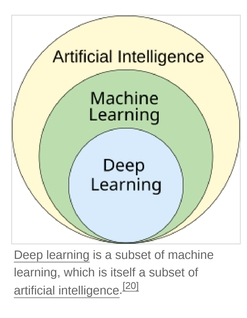


[3] Score: 0.6645 | Doc: sample_ai_article.pdf | Type: text


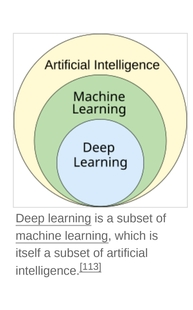

In [27]:
async def search(query: str, collection: str = "multimodal_data", top_k: int = 3) -> dict:
    """Search for relevant document chunks without generating an answer."""
    payload = {
        "query": query,
        "collection_names": [collection],
        "reranker_top_k": top_k
    }
    
    async with aiohttp.ClientSession() as session:
        async with session.post(f"{RAG_BASE_URL}/v1/search", json=payload) as resp:
            return await resp.json()

import base64
from IPython.display import display, Image as IPImage

def is_base64_image(content: str) -> bool:
    """Check if content is base64 image data."""
    return content.startswith(("/9j/", "iVBOR", "data:image"))

def display_content(content: str, max_len: int = 200):
    """Display content - renders images, truncates text."""
    if is_base64_image(content):
        # Decode and display image
        try:
            # Handle data:image prefix if present
            if content.startswith("data:image"):
                content = content.split(",", 1)[1]
            img_data = base64.b64decode(content)
            display(IPImage(data=img_data, width=400))
        except Exception as e:
            print(f"    [Image decode error: {e}]")
    else:
        # Display text
        text = content[:max_len].replace("\n", " ").strip()
        text = text + "..." if len(content) > max_len else text
        print(f"    {text}")

# Test the search endpoint
print("Testing /v1/search endpoint...")
print("=" * 60)
results = await search("What is artificial intelligence?", top_k=3)

print(f"Found {len(results.get('results', []))} results:\n")
for i, result in enumerate(results.get("results", []), 1):
    score = result.get("score", 0)
    content = result.get("content", "")
    doc_name = result.get("document_name", "unknown")
    content_type = result.get("type", "text")
    
    print(f"[{i}] Score: {score:.4f} | Doc: {doc_name} | Type: {content_type}")
    display_content(content)
    print()

### 4.6 Compare: LLM vs RAG


In [28]:
QUESTION = "What are the main approaches to artificial intelligence?"

print("=" * 60)
print("WITHOUT RAG (LLM general knowledge only)")
print("=" * 60)
print(f"Q: {QUESTION}")
print("A: ", end="")
await chat(QUESTION, use_rag=False)

print()
print("=" * 60)
print("WITH RAG (searches your documents first)")
print("=" * 60)
print(f"Q: {QUESTION}")
print("A: ", end="")
await chat(QUESTION, use_rag=True)

WITHOUT RAG (LLM general knowledge only)
Q: What are the main approaches to artificial intelligence?
A: The main approaches to artificial intelligence are symbolic AI, connectionism, and statistical AI.

WITH RAG (searches your documents first)
Q: What are the main approaches to artificial intelligence?
A: Okay, let's tackle the question about the main approaches to artificial intelligence based on the provided context. First, I need to go through the text carefully to identify the different approaches mentioned.

The user provided several pages of content. Let me start by skimming through each section to pick out the key terms and concepts related to AI approaches. 

Looking at the first part, there's a mention of the symbolic approach, which failed in tasks like learning and object recognition. Then there's Moravec's paradox, which contrasts high-level intelligent tasks with low-level instinctive ones. Hubert Dreyfus's critique of symbolic AI and his emphasis on unconscious instinct 

'Okay, let\'s tackle the question about the main approaches to artificial intelligence based on the provided context. First, I need to go through the text carefully to identify the different approaches mentioned.\n\nThe user provided several pages of content. Let me start by skimming through each section to pick out the key terms and concepts related to AI approaches. \n\nLooking at the first part, there\'s a mention of the symbolic approach, which failed in tasks like learning and object recognition. Then there\'s Moravec\'s paradox, which contrasts high-level intelligent tasks with low-level instinctive ones. Hubert Dreyfus\'s critique of symbolic AI and his emphasis on unconscious instinct and "feel" for situations is noted. The text also discusses the resurgence of interest in symbolic AI due to explainability concerns, leading to neuro-symbolic AI as a bridge between symbolic and sub-symbolic methods.\n\nNext, the text talks about "Neats" and "Scruffies." Neats rely on theoretical

### 4.7 Ask Your Own Questions


In [29]:
# Edit this question and run the cell
my_question = "What is machine learning?"

print(f"Q: {my_question}")
print("A: ", end="")
await chat(my_question, use_rag=True)

Q: What is machine learning?
A: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. It involves creating systems that improve their performance on a given task automatically through experience. ML algorithms are designed to identify patterns in data, make decisions, or predictions based on that data, and adapt as they are exposed to new information. The field encompasses various techniques, including supervised learning (where models are trained on labeled data), unsupervised learning (where models identify patterns in unlabeled data), and reinforcement learning (where models learn by interacting with an environment and receiving feedback in the form of rewards or penalties). ML has applications across numerous domains, such as natural language processing, computer vision, speech recognition, an

'Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. It involves creating systems that improve their performance on a given task automatically through experience. ML algorithms are designed to identify patterns in data, make decisions, or predictions based on that data, and adapt as they are exposed to new information. The field encompasses various techniques, including supervised learning (where models are trained on labeled data), unsupervised learning (where models identify patterns in unlabeled data), and reinforcement learning (where models learn by interacting with an environment and receiving feedback in the form of rewards or penalties). ML has applications across numerous domains, such as natural language processing, computer vision, speech recognition, and predictive analytics.\n'

---

# Section 5: Cleanup

---

### 5.1 Delete Uploaded Documents

In [ ]:
# Delete all uploaded documents
doc_names = [filename for filename, _ in SAMPLE_DOCS]
await delete_document(doc_names, collection=COLLECTION_NAME)

In [ ]:
# List all collections and delete each one
collections = await list_collections()

if collections:
    print(f"\nDeleting {len(collections)} collection(s)...")
    for c in collections:
        name = c.get("collection_name", c) if isinstance(c, dict) else c
        await delete_collection(name)
    
    print("\n✅ All collections deleted")
    
    # Verify
    await list_collections()
else:
    print("No collections to delete")

### 5.2 Stop All Services

In [ ]:
stop_all()

---

# Quick Reference

---

## Function Cheat Sheet

| Function | Description |
|----------|-------------|
| `deploy_all()` | Start all services |
| `stop_all()` | Stop all services |
| `check_containers()` | List running containers |
| `await chat(question)` | Ask a question (`use_rag=True` by default) |
| `await chat(question, use_rag=False)` | Ask LLM directly without document search |
| `await upload_documents(paths)` | Upload file(s) or directory to knowledge base |
| `await list_documents()` | List uploaded files |
| `await delete_document(name)` | Remove a file |
| `await list_collections()` | List all collections |

---

## Troubleshooting

| Issue | Solution |
|-------|----------|
| Containers not starting | Run `docker logs <container-name>` to see errors |
| Out of GPU memory | Run `stop_all()`, or use NVIDIA-hosted LLM |
| API not responding | Wait for "healthy" status, check `docker logs rag-server` |
| Upload stuck | Check `docker logs ingestor-server` |

---

## Service Ports

| Service | Port |
|---------|------|
| RAG Server | 8081 |
| Ingestor Server | 8082 |
| RAG Frontend | 8090 |
| Milvus | 19530 |

---

# Next Steps

---

Now that you've deployed the RAG Blueprint and tested basic functionality, explore these notebooks to learn more advanced features:

## 🟢 Beginner - Learn the APIs

| Notebook | Description |
|----------|-------------|
| **ingestion_api_usage.ipynb** | Deep dive into the ingestion service - upload, process, and manage documents |
| **retriever_api_usage.ipynb** | Explore query techniques, retrieval strategies, and search parameters |

## 🟡 Intermediate - Extend Functionality

| Notebook | Description |
|----------|-------------|
| **summarization.ipynb** | Document summarization with page filtering and multiple strategies |
| **nb_metadata.ipynb** | Metadata ingestion, filtering, and extraction for enhanced retrieval |
| **rag_library_usage.ipynb** | Native Python client usage - full end-to-end API examples |
| **rag_library_lite_usage.ipynb** | Containerless deployment with Milvus Lite (no Docker required) |
| **evaluation_01_ragas.ipynb** | Evaluate RAG quality using RAGAS metrics |
| **evaluation_02_recall.ipynb** | Measure retrieval recall at various top-k thresholds |

## 🔴 Advanced - Build & Customize

| Notebook | Description |
|----------|-------------|
| **image_input.ipynb** | Multimodal queries with text + images (VLM embeddings) |
| **building_rag_vdb_operator.ipynb** | Create custom vector database operators (e.g., OpenSearch) |
| **mcp_server_usage.ipynb** | Use Model Context Protocol (MCP) transports instead of REST APIs |

## 📚 Additional Resources

- **Documentation**: https://docs.nvidia.com/ai-blueprints/rag/latest/
- **GitHub**: https://github.com/NVIDIA-AI-Blueprints/rag
- **Support Matrix**: https://docs.nvidia.com/ai-blueprints/rag/latest/support-matrix.html

---

**Happy building! 🚀**